We want to discover 1) which cows are getting lesions, 2) the seriousness of the lesions and their frequencies, 3) commonalities in the cows getting lesions. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.interpolate
from scipy.interpolate import make_interp_spline
import datetime
import pymc as pm
import arviz as az
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [2]:
mobility = pd.read_csv("/Users/abbystokes/Documents/GitHub/CSCI5707/CE DATA.csv")
mobility.head()

,Cow ID,Mobility Score,Time
0,10161,51.0,2023-10-15T21:03:17.000Z
1,10823,39.0,2023-10-15T21:02:47.000Z
2,10811,36.0,2023-10-15T21:02:44.000Z
3,11147,47.0,2023-10-15T21:02:38.000Z
4,10550,68.0,2023-10-15T21:02:30.000Z


In [3]:

print("Average Mobility Score: ",np.mean(mobility['Mobility Score']))
mobility["Time"] = pd.to_datetime(mobility["Time"])


Average Mobility Score:  37.69952235870684


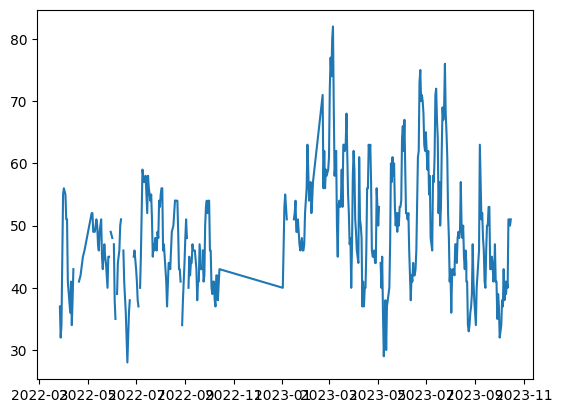

In [4]:
#Looking at one cow
df = mobility[mobility['Cow ID'] == 10161]
df = df.set_index('Time')


plt.plot(df.index, df['Mobility Score'])


In [5]:
demo = pd.read_csv("/Users/abbystokes/Documents/GitHub/CSCI5707/rolling_demo.csv")
demo.head()

,_provider_name,_owner_id,_transfer_id,_date_collected,_record_id,_process_id,stage_name,src_tag_id,birth_date,birth_weight,...,DAMID,DMTAG,LMSV,LMSFD,TDAT,MILK,WMK1,TWIN,XLAME,LXLAM
0,dc305_animals,38,FILEOUT93_6502af7eb33f02de8fbd352b,2023-09-14T07:00:40.891Z,6502af99e8fdd5d4a0085653,6502af98120a46269f2be432,Pregnant,14,0000-00-00,NaN,...,8,73945962,25,09/13/23,08/29/23,86,NaN,-,0,0
1,dc305_animals,38,FILEOUT93_6502af7eb33f02de8fbd352b,2023-09-14T07:00:40.891Z,6502af99e8fdd5d4a0085654,6502af98120a46269f2be432,Pregnant,181,0000-00-00,NaN,...,1516,143499866,18,09/13/23,08/29/23,83,NaN,T,0,0
2,dc305_animals,38,FILEOUT93_6502af7eb33f02de8fbd352b,2023-09-14T07:00:40.891Z,6502af99e8fdd5d4a0085655,6502af98120a46269f2be432,Pregnant,231,0000-00-00,NaN,...,1690,41LDT8147,28,09/13/23,08/29/23,84,NaN,-,1,0
3,dc305_animals,38,FILEOUT93_6502af7eb33f02de8fbd352b,2023-09-14T07:00:40.891Z,6502af99e8fdd5d4a0085656,6502af98120a46269f2be432,Pregnant,261,0000-00-00,NaN,...,1027,144509191,36,09/13/23,08/29/23,87,NaN,-,0,0
4,dc305_animals,38,FILEOUT93_6502af7eb33f02de8fbd352b,2023-09-14T07:00:40.891Z,6502af99e8fdd5d4a0085657,6502af98120a46269f2be432,Pregnant,271,0000-00-00,NaN,...,1697,144793534,21,09/13/23,08/29/23,76,NaN,-,0,0


In [6]:
events = pd.read_csv("/Users/abbystokes/Documents/GitHub/CSCI5707/rolling_events.csv")
events.head()

,Unnamed: 0,_date_collected,_hash_key,_owner_id,_process_id,_provider_name,_record_id,_transfer_id,bred_gap,bred_reason,...,from_pen_id,remark,result,src_event_id,src_protocol,src_tag_id,src_technician_id,src_descr,technician_name,to_pen_id
0,1,2023-09-11T06:00:41.912Z,NaN,38,64fead09325067d3583775b9,dc305_events,64fead0a11c26e47ea0e6c66,EVT99_64feacf09ef0c9b377b3fc81,NaN,NaN,...,NaN,75 DAYS,NaN,OK,NaN,14,NaN,NaN,NaN,NaN
1,2,2023-09-11T06:00:41.912Z,NaN,38,64fead09325067d3583775b9,dc305_events,64fead0a11c26e47ea0e6c67,EVT99_64feacf09ef0c9b377b3fc81,NaN,NaN,...,NaN,72 DAYS,NaN,OK,NaN,181,NaN,NaN,NaN,NaN
2,3,2023-09-11T06:00:41.912Z,NaN,38,64fead09325067d3583775b9,dc305_events,64fead0a11c26e47ea0e6c68,EVT99_64feacf09ef0c9b377b3fc81,NaN,NaN,...,NaN,NONE,NaN,FOOTRIM,NaN,181,NaN,NaN,NaN,NaN
3,4,2023-09-11T06:00:41.912Z,NaN,38,64fead09325067d3583775b9,dc305_events,64fead0a11c26e47ea0e6c69,EVT99_64feacf09ef0c9b377b3fc81,NaN,NaN,...,NaN,HFR,NaN,OK,NaN,231,NaN,NaN,NaN,NaN
4,5,2023-09-11T06:00:41.912Z,NaN,38,64fead09325067d3583775b9,dc305_events,64fead0a11c26e47ea0e6c6a,EVT99_64feacf09ef0c9b377b3fc81,NaN,NaN,...,NaN,90 DAYS,NaN,OK,NaN,231,NaN,NaN,NaN,NaN


In [7]:
events.describe()

,Unnamed: 0,_hash_key,_owner_id,bred_gap,bred_reason,bred_result,days_in_milk,event_time_local,event_time_utc,from_pen_id,src_tag_id,src_technician_id,src_descr,to_pen_id
count,4086.000000,0.0,4086.0,0.0,0.0,0.0,4086.000000,0.0,0.0,0.0,4086.000000,419.000000,0.0,0.0
mean,2043.500000,NaN,38.0,NaN,NaN,NaN,229.679638,NaN,NaN,NaN,11001.201419,5.615752,NaN,NaN
std,1179.670929,NaN,0.0,NaN,NaN,NaN,197.563046,NaN,NaN,NaN,1924.690141,2.899899,NaN,NaN
min,1.000000,NaN,38.0,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,14.000000,1.000000,NaN,NaN
25%,1022.250000,NaN,38.0,NaN,NaN,NaN,64.000000,NaN,NaN,NaN,10288.000000,3.000000,NaN,NaN
50%,2043.500000,NaN,38.0,NaN,NaN,NaN,201.000000,NaN,NaN,NaN,11332.000000,7.000000,NaN,NaN
75%,3064.750000,NaN,38.0,NaN,NaN,NaN,348.000000,NaN,NaN,NaN,12275.000000,7.000000,NaN,NaN
max,4086.000000,NaN,38.0,NaN,NaN,NaN,946.000000,NaN,NaN,NaN,13326.000000,10.000000,NaN,NaN


Text(0.5, 0, 'Days')

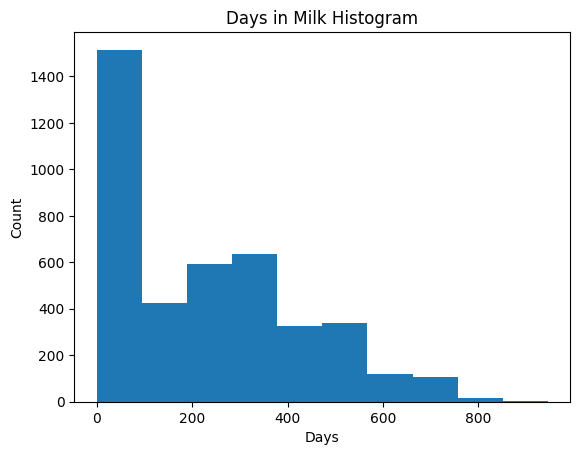

In [8]:
plt.hist(events['days_in_milk'])
plt.title("Days in Milk Histogram")
plt.ylabel("Count")
plt.xlabel("Days")

In [9]:
#Days in Milk vs Lameness history (never, once, twice, chronic) by lactation period

In [10]:
demo = pd.read_csv("/Users/abbystokes/Documents/GitHub/CSCI5707/Cow_Demographics.csv")
demo.head()

,Farm,cowid,birth_date,ear_tag_id
0,409,2,2016-07-09,840003202970166
1,409,3,2021-03-26,840003252641789
2,409,5,2021-03-26,840003251558524
3,409,6,2019-03-26,840003252641799
4,409,7,2020-01-01,840003211300538


In [11]:
leave = pd.read_csv("/Users/abbystokes/Documents/GitHub/CSCI5707/Cows_Leave_Herd.csv")
leave

,Farm,cowid,Leave_Date
0,38,1111,2023-10-23
1,38,1375,2023-07-07
2,38,6530,2022-10-25
3,38,6614,2023-01-31
4,38,6732,2023-05-16
...,...,...,...
8882,13735,819639,2023-10-11
8883,13735,891401,2023-11-01
8884,13735,894334,2023-09-19
8885,13735,895024,2023-09-11


In [12]:
lame = pd.read_csv("/Users/abbystokes/Documents/GitHub/CSCI5707/Lame_Events.csv")
lame
lame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14184 entries, 0 to 14183
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Farm           14184 non-null  int64 
 1   cowid          14184 non-null  int64 
 2   Event          14184 non-null  object
 3   Days_In_Milk   14184 non-null  int64 
 4   Event_Date     14184 non-null  object
 5   Recode_Protos  14184 non-null  object
dtypes: int64(3), object(3)
memory usage: 665.0+ KB


array([<Axes: title={'center': 'LAME'}>,
       <Axes: title={'center': 'NO_LESION'}>], dtype=object)

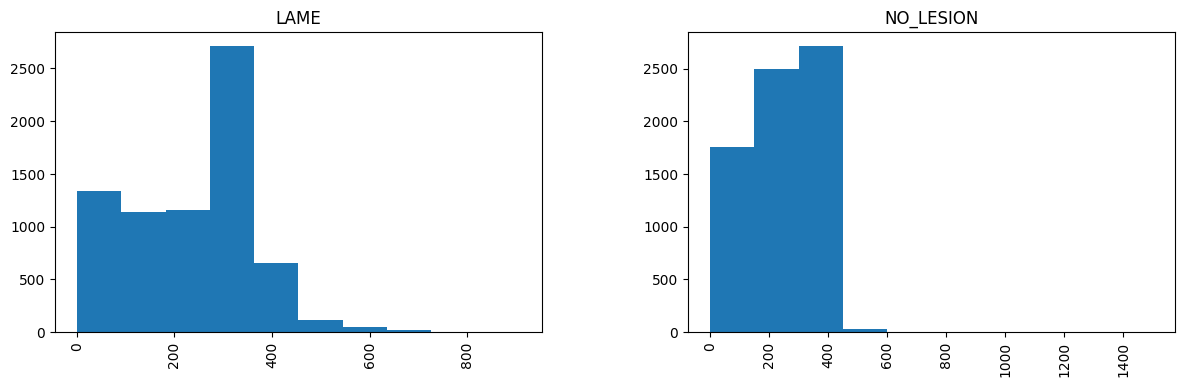

In [13]:
#Days in milk by lameness
lame.hist(column='Days_In_Milk', by='Event', bins=10,figsize=(14,4))

In [14]:
lesion = pd.read_csv("/Users/abbystokes/Documents/GitHub/CSCI5707/Lesion_Type.csv")
lesion
lesion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Recode_Protos         11 non-null     object
 1   Proto_Classification  11 non-null     object
dtypes: object(2)
memory usage: 308.0+ bytes


In [15]:
lact = pd.read_csv("/Users/abbystokes/Documents/GitHub/CSCI5707/Lactation.csv")
lact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58452 entries, 0 to 58451
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Farm        58452 non-null  int64 
 1   lactation   58452 non-null  int64 
 2   cowid       58452 non-null  int64 
 3   fresh_date  58452 non-null  object
 4   birth_date  58452 non-null  object
 5   ear_tag_id  53572 non-null  object
dtypes: int64(3), object(3)
memory usage: 2.7+ MB


In [16]:
#Merge Lact and Lesion
df = lame.merge(lact, how = "inner", on = ['cowid'])
df
now = datetime.datetime.now()
df['birth_date'] = pd.to_datetime(df['birth_date'])
df['Age'] = (now - df['birth_date']).dt.days
df['label'] = 1
df.loc[df['Event'] == 'NO_LESION', 'label'] = 0
df



,Farm_x,cowid,Event,Days_In_Milk,Event_Date,Recode_Protos,Farm_y,lactation,fresh_date,birth_date,ear_tag_id,Age,label
0,38,14,NO_LESION,95,2023-06-19,Trim Only,409,1,2023-01-19,2021-03-26,840003262436235,981,0
1,38,181,NO_LESION,204,2023-08-28,Trim Only,13733,0,0000-00-00,2022-05-07,840003255333167,574,0
2,38,181,NO_LESION,204,2023-08-28,Trim Only,13735,3,2022-11-06,2018-10-12,982000425890121,1877,0
3,13735,181,NO_LESION,324,2023-09-26,Trim Only,13733,0,0000-00-00,2022-05-07,840003255333167,574,0
4,13735,181,NO_LESION,324,2023-09-26,Trim Only,13735,3,2022-11-06,2018-10-12,982000425890121,1877,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14668,13735,818864,NO_LESION,287,2023-10-10,Trim Only,13735,1,2022-12-27,2021-03-07,840003228002468,1000,0
14669,13735,818905,NO_LESION,301,2023-10-31,Trim Only,13735,1,2023-01-03,2021-01-29,840003230526297,1037,0
14670,13735,818999,NO_LESION,292,2023-11-07,Trim Only,13735,1,2023-01-19,2021-04-05,840003228002368,971,0
14671,13735,819002,NO_LESION,271,2023-10-17,Trim Only,13735,1,2023-01-19,2021-03-23,840003228002527,984,0


In [17]:
df = df.merge(lesion, how='left', on='Recode_Protos')


In [18]:
df

,Farm_x,cowid,Event,Days_In_Milk,Event_Date,Recode_Protos,Farm_y,lactation,fresh_date,birth_date,ear_tag_id,Age,label,Proto_Classification
0,38,14,NO_LESION,95,2023-06-19,Trim Only,409,1,2023-01-19,2021-03-26,840003262436235,981,0,Trim Only
1,38,181,NO_LESION,204,2023-08-28,Trim Only,13733,0,0000-00-00,2022-05-07,840003255333167,574,0,Trim Only
2,38,181,NO_LESION,204,2023-08-28,Trim Only,13735,3,2022-11-06,2018-10-12,982000425890121,1877,0,Trim Only
3,13735,181,NO_LESION,324,2023-09-26,Trim Only,13733,0,0000-00-00,2022-05-07,840003255333167,574,0,Trim Only
4,13735,181,NO_LESION,324,2023-09-26,Trim Only,13735,3,2022-11-06,2018-10-12,982000425890121,1877,0,Trim Only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14668,13735,818864,NO_LESION,287,2023-10-10,Trim Only,13735,1,2022-12-27,2021-03-07,840003228002468,1000,0,Trim Only
14669,13735,818905,NO_LESION,301,2023-10-31,Trim Only,13735,1,2023-01-03,2021-01-29,840003230526297,1037,0,Trim Only
14670,13735,818999,NO_LESION,292,2023-11-07,Trim Only,13735,1,2023-01-19,2021-04-05,840003228002368,971,0,Trim Only
14671,13735,819002,NO_LESION,271,2023-10-17,Trim Only,13735,1,2023-01-19,2021-03-23,840003228002527,984,0,Trim Only


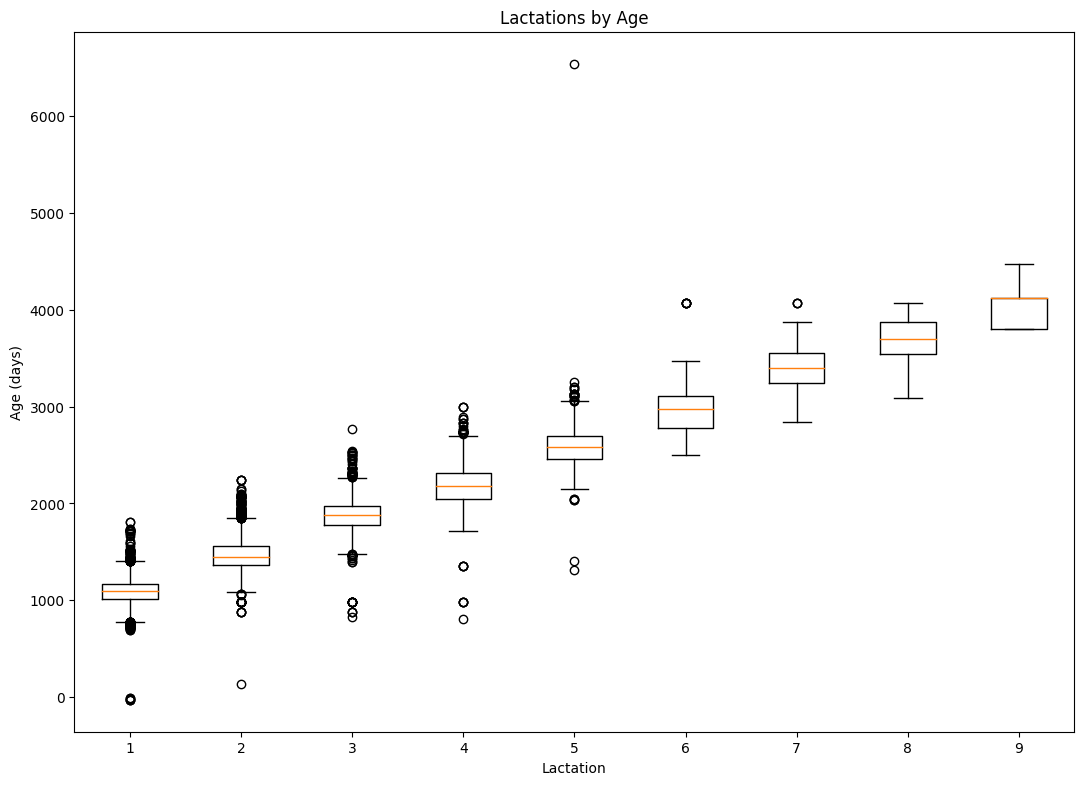

In [19]:
# Whisker Plot
data_1 = df[df['lactation'] == 1].Age
data_2 = df[df['lactation'] == 2].Age
data_3 = df[df['lactation'] == 3].Age
data_4 = df[df['lactation'] == 4].Age
data_5 = df[df['lactation'] == 5].Age
data_6 = df[df['lactation'] == 6].Age
data_7 = df[df['lactation'] == 7].Age
data_8 = df[df['lactation'] == 8].Age
data_9 = df[df['lactation'] == 9].Age
data = [data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9]
 
fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(data)

plt.title("Lactations by Age")
plt.xlabel("Lactation")
plt.ylabel('Age (days)')
 
# show plot
plt.show()

In [20]:
#digital dermatitis , sole ulcer, white line diseases 3 logistic regression each class as trim or one of the three

# trim only vs infectious v non infectious

# include CE score and farm

In [21]:
#g = sns.pairplot(data=df, hue='Event', height = 4)
#g.fig.suptitle("Lameness by Days in Milk, Age, and Lactations", y=1.08)

Build Logistic Regression Model


In [22]:
# Logistic model Cleaning
features = ['Days_In_Milk', 'lactation', 'Age', 'Farm_x']
#features = ['Days_In_Milk', 'lactation', 'Age']

df_trim = df[df['Proto_Classification'] == 'Trim Only']
df_dd = df[df['Recode_Protos'] == 'DigitalDermatitis']
df_dd = pd.concat([df_trim, df_dd], ignore_index=True, axis=0)
df_su = df[df['Recode_Protos'] == 'SoleUlcer']
df_su = pd.concat([df_trim, df_su], ignore_index=True, axis=0)
df_wu = df[df['Recode_Protos'] == 'WhiteLineDisease']
df_wu = pd.concat([df_trim, df_wu], ignore_index=True, axis=0)


In [41]:
#Digital Dermatitis

X_train, X_test, y_train, y_test = train_test_split(df_dd[features], df_dd['label'], test_size=0.25, random_state=16)

# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=16)

# fit the model with data
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

In [42]:
X_train.shape

(8860, 4)

In [43]:
X_test.shape

(2954, 4)

Text(0.5, 427.9555555555555, 'Predicted label')

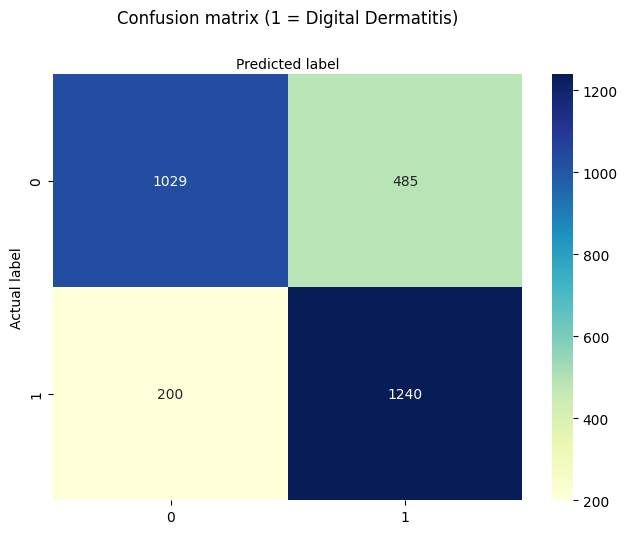

In [25]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix (1 = Digital Dermatitis)', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')



In [26]:
# Classification Report
target_names = ['without lesion', 'with lesion']
print(classification_report(y_test, y_pred, target_names=target_names))

                precision    recall  f1-score   support

without lesion       0.84      0.68      0.75      1514
   with lesion       0.72      0.86      0.78      1440

      accuracy                           0.77      2954
     macro avg       0.78      0.77      0.77      2954
  weighted avg       0.78      0.77      0.77      2954



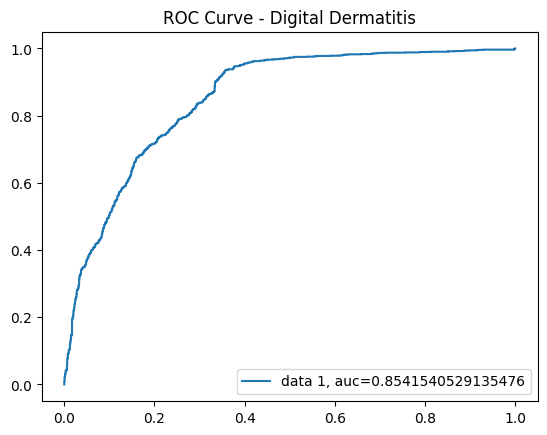

In [27]:
# Roc Curve
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title("ROC Curve - Digital Dermatitis")
plt.show()

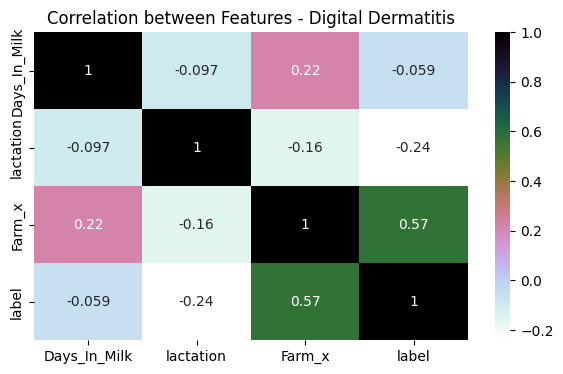

In [28]:
features1 = ['Days_In_Milk', 'lactation', 'Farm_x', 'label']

plt.figure(figsize=(7,4)) 
sns.heatmap(df_dd[features1].corr(), annot=True, cmap='cubehelix_r')
plt.title("Correlation between Features - Digital Dermatitis")
plt.show()

Text(0.5, 427.9555555555555, 'Predicted label')

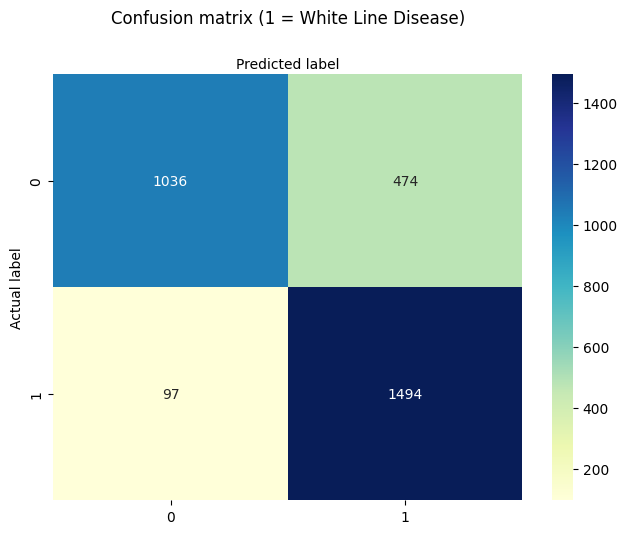

In [29]:
# White Ulcer
X_train, X_test, y_train, y_test = train_test_split(df_wu[features], df_wu['label'], test_size=0.25, random_state=16)

# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=16)

# fit the model with data
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix (1 = White Line Disease)', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [30]:
target_names = ['without lesion', 'with lesion']
print(classification_report(y_test, y_pred, target_names=target_names))

                precision    recall  f1-score   support

without lesion       0.91      0.69      0.78      1510
   with lesion       0.76      0.94      0.84      1591

      accuracy                           0.82      3101
     macro avg       0.84      0.81      0.81      3101
  weighted avg       0.83      0.82      0.81      3101



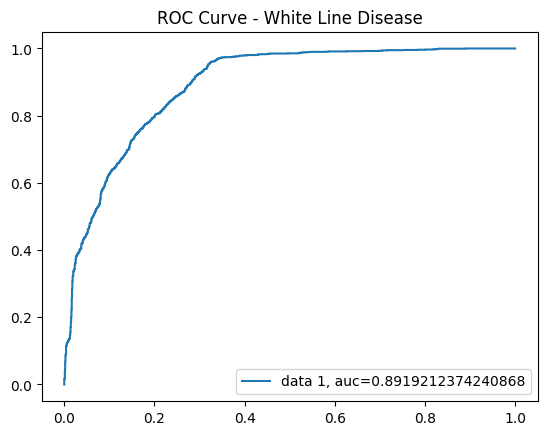

In [31]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title("ROC Curve - White Line Disease")
plt.show()

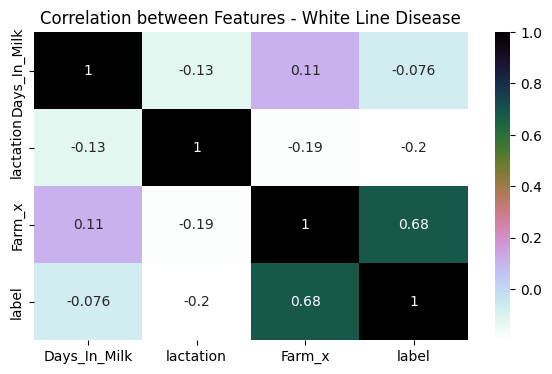

In [32]:
features1 = ['Days_In_Milk', 'lactation', 'Farm_x', 'label']

plt.figure(figsize=(7,4)) 
sns.heatmap(df_wu[features1].corr(), annot=True, cmap='cubehelix_r')
plt.title("Correlation between Features - White Line Disease")
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: 

Text(0.5, 1.08, 'Lameness by Days in Milk, Lactations, and Farm')

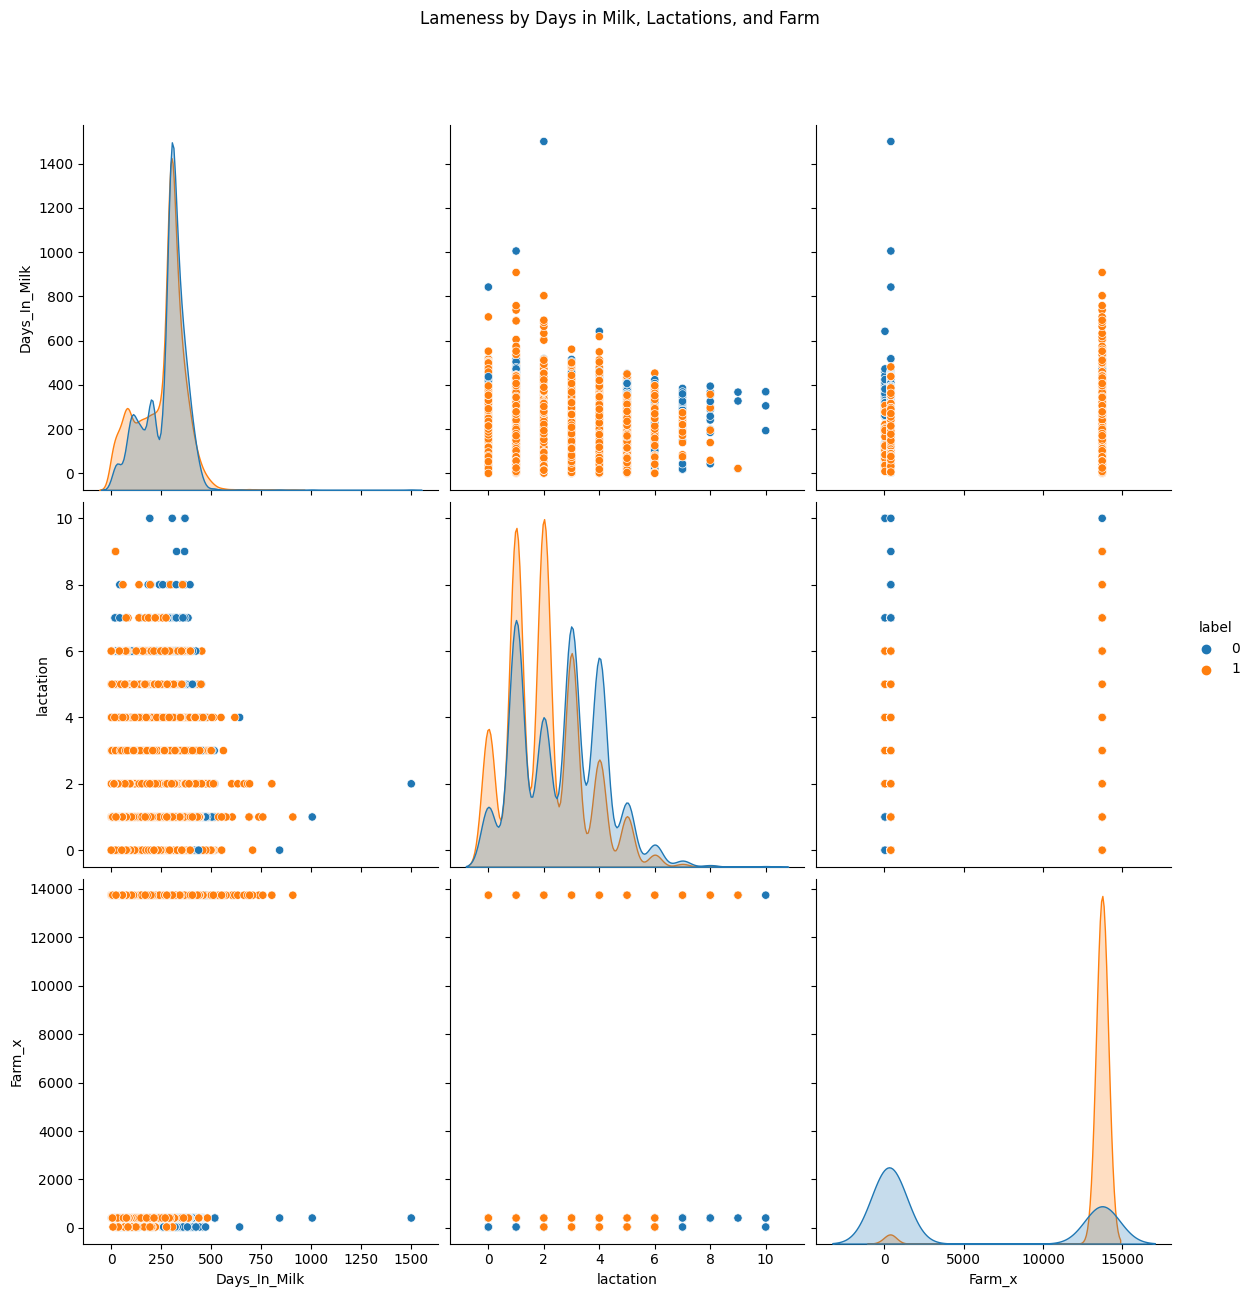

In [33]:
g = sns.pairplot(data=df_wu[features1], hue='label', height = 4)
g.fig.suptitle("Lameness by Days in Milk, Lactations, and Farm", y=1.08)

Text(0.5, 427.9555555555555, 'Predicted label')

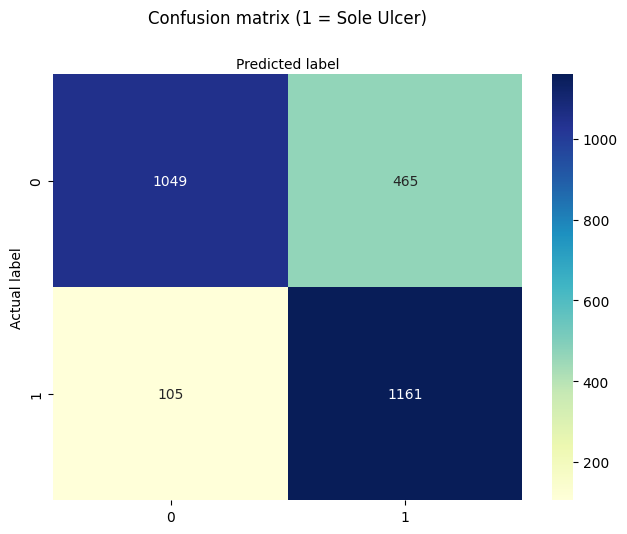

In [34]:
# Sole Ulcer
X_train, X_test, y_train, y_test = train_test_split(df_su[features], df_su['label'], test_size=0.25, random_state=16)

# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=16)

# fit the model with data
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix (1 = Sole Ulcer)', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [35]:
target_names = ['without lesion', 'with lesion']
print(classification_report(y_test, y_pred, target_names=target_names))

                precision    recall  f1-score   support

without lesion       0.91      0.69      0.79      1514
   with lesion       0.71      0.92      0.80      1266

      accuracy                           0.79      2780
     macro avg       0.81      0.80      0.79      2780
  weighted avg       0.82      0.79      0.79      2780



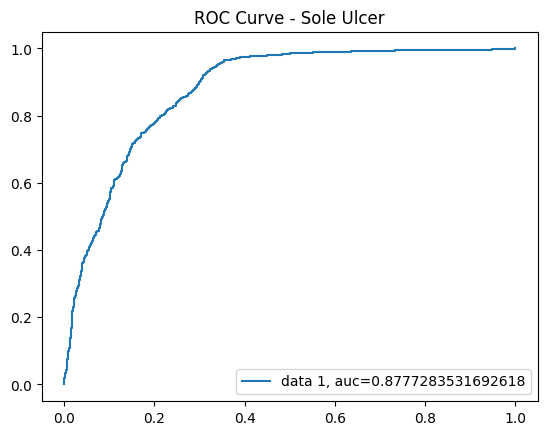

In [36]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title("ROC Curve - Sole Ulcer")
plt.show()

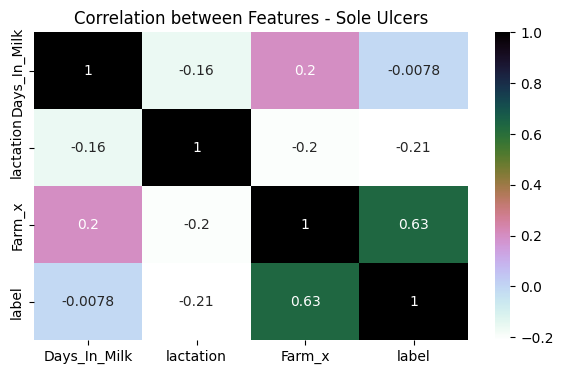

In [37]:
features1 = ['Days_In_Milk', 'lactation', 'Farm_x', 'label']

plt.figure(figsize=(7,4)) 
sns.heatmap(df_su[features1].corr(), annot=True, cmap='cubehelix_r')
plt.title("Correlation between Features - Sole Ulcers")
plt.show()

In [38]:
#SVM
from sklearn import svm
clf = svm.SVC()
clf.fit(X, y)
clf.support_vectors_

NameError: name 'X' is not defined

Text(0, 0.5, 'Lactations')

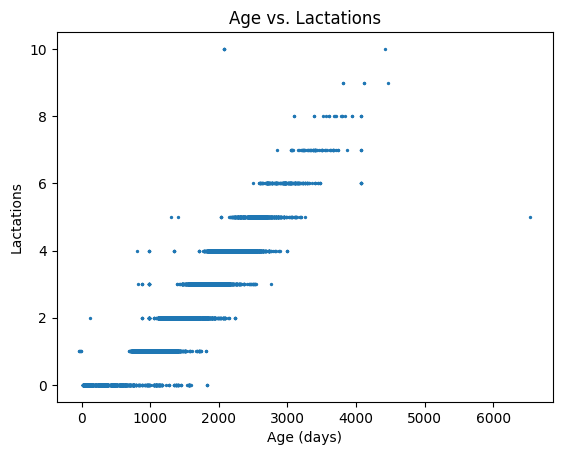

In [ ]:
plt.scatter(data=X, x='Age', y='lactation', s=2)
plt.title('Age vs. Lactations')
plt.xlabel("Age (days)")
plt.ylabel("Lactations")

In [ ]:
df[df['lactation'] == 0].Age

1         573
3         573
6         571
7         568
8         568
         ... 
13465     625
13467     625
13469     625
13471     624
14433    1453
Name: Age, Length: 1290, dtype: int64

In [ ]:
# Plot proportion of each disease by farm
